In [2]:
# Preamble - Execute only once

%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

In [3]:
# Preamble
import logging
logging.basicConfig(level=logging.DEBUG)

# stdlib
from os.path import basename, exists, join as pjoin, realpath
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

#external
from IPython.display import Image
#from py7zr import SevenZipFile

# self
from src import bbox, gdal_slope_util as S
# from src.gdal_slope_util import check_run, DFLT_OPT, ZSTD_OPT, TILE_OPT

# CPL_ZIP_ENCODING for gdal vsizip:  https://github.com/conda-forge/gdal-feedstock/issues/83
os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'

### IGN Lidar HD

#### Step 1 Laz list

extract all links from the html files
the goal is to build links like
https://data.geopf.fr/wms-r?SERVICE=WMS&VERSION=1.3.0&EXCEPTIONS=text/xml&REQUEST=GetMap&LAYERS=IGNF_LIDAR-HD_MNT_ELEVATION.ELEVATIONGRIDCOVERAGE.LAMB93&FORMAT=image/geotiff&STYLES=&CRS=EPSG:2154&BBOX=1031999.75,6354000.25,1032999.75,6355000.25&WIDTH=2000&HEIGHT=2000&FILENAME=LHD_FXX_1032_6355_MNT_O_0M50_LAMB93_IGN69.tif
https://data.geopf.fr/wms-r?SERVICE=WMS&VERSION=1.3.0&EXCEPTIONS=text/xml&REQUEST=GetMap&LAYERS=IGNF_LIDAR-HD_MNT_ELEVATION.ELEVATIONGRIDCOVERAGE.LAMB93&FORMAT=image/geotiff&STYLES=&CRS=EPSG:2154&BBOX=1053999.75,6346000.25,1054999.75,6347000.25&WIDTH=2000&HEIGHT=2000&FILENAME=LHD_FXX_1054_6347_MNT_O_0M50_LAMB93_IGN69.tif
https://data.geopf.fr/wms-r?SERVICE=WMS&VERSION=1.3.0&EXCEPTIONS=text/xml&REQUEST=GetMap&LAYERS=IGNF_LIDAR-HD_MNT_ELEVATION.ELEVATIONGRIDCOVERAGE.LAMB93&FORMAT=image/geotiff&STYLES=&CRS=EPSG:2154&BBOX=1054999.75,6346000.25,1055999.75,6347000.25&WIDTH=2000&HEIGHT=2000&FILENAME=LHD_FXX_1055_6347_MNT_O_0M50_LAMB93_IGN69.tif
https://data.geopf.fr/wms-r?SERVICE=WMS&VERSION=1.3.0&EXCEPTIONS=text/xml&REQUEST=GetMap&LAYERS=IGNF_LIDAR-HD_MNT_ELEVATION.ELEVATIONGRIDCOVERAGE.LAMB93&FORMAT=image/geotiff&STYLES=&CRS=EPSG:2154&BBOX=1053999.75,6345000.25,1054999.75,6346000.25&WIDTH=2000&HEIGHT=2000&FILENAME=LHD_FXX_1054_6346_MNT_O_0M50_LAMB93_IGN69.tif

**Is the file name important? ( FILENAME) **
Technically, no. The server uses the BBOX and LAYERS parameters to decide what content to send you. If you change the FILENAME parameter to my_map.tif, the downloaded file will contain the exact same data, just named differently.
However, for organization, yes. The naming convention used in your examples is very specific and helpful: LHD_FXX_1055_6347_MNT_O_0M50_LAMB93_IGN69.tif
- 1055: The Min X coordinate in kilometers (1,055,000 meters).
- 6347: The Max Y coordinate in kilometers (6,347,000 meters). Note: This usually refers to the top-left corner.
- 0M50: The resolution (0.5 meters).


#### Annex - Mountains
Alps:
QK Leman/MB
QL Lauziere
RL Haute Maurienne
PM Gre
QM Maurienn
RM Haute Maurienne
QN Ecrins
RN Queyras
RO Tinée
SP vesubi

Pyrénees: EQ ER FR GR HR IR (JR) JS KS LS

In [41]:
rawfolder = NBROOT + '/data/dtm_local/lidarhd_raw/'
try: os.mkdir(rawfolder)
except FileExistsError: pass
os.chdir(rawfolder)

In [1]:
!mkdir -p laz-lists

In [15]:
%%bash
for fold in PK QK PL QL RL PM QM RM PN QN RN PO QO RO PP QP RP SP RQ EQ ER FR GR HR IR JR JS KS LS; do
  wget https://storage.sbg.cloud.ovh.net/v1/AUTH_63234f509d6048bca3c9fd7928720ca1/ppk-lidar/$fold/  -O ./laz-lists/$fold.html ;
  cat ./laz-lists/$fold.html | grep -oP 'LHD_FXX_\d+_\d+' > $fold.txt
done


--2026-01-13 08:54:51--  https://storage.sbg.cloud.ovh.net/v1/AUTH_63234f509d6048bca3c9fd7928720ca1/ppk-lidar/PK/
Resolving storage.sbg.cloud.ovh.net (storage.sbg.cloud.ovh.net)... 54.38.230.76
Connecting to storage.sbg.cloud.ovh.net (storage.sbg.cloud.ovh.net)|54.38.230.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662114 (647K) [text/html]
Saving to: ‘./laz-lists/PK.html’

     0K .......... .......... .......... .......... ..........  7% 1,20M 0s
    50K .......... .......... .......... .......... .......... 15%  156M 0s
   100K .......... .......... .......... .......... .......... 23% 2,37M 0s
   150K .......... .......... .......... .......... .......... 30%  165M 0s
   200K .......... .......... .......... .......... .......... 38% 2,47M 0s
   250K .......... .......... .......... .......... .......... 46% 92,4M 0s
   300K .......... .......... .......... .......... .......... 54%  104M 0s
   350K .......... .......... .......... .......... .......

In [ ]:
# high-prio  QK QL RL PM QM QN RN RO SP  ;
!for fold in PK QK PL QL RL PM QM RM PN QN RN PO QO RO PP QP RP SP RQ EQ ER FR GR HR IR JR JS KS LS; do wget https://storage.sbg.cloud.ovh.net/v1/AUTH_63234f509d6048bca3c9fd7928720ca1/ppk-lidar/$fold/  -O ./laz-lists/$fold.html ; done


In [ ]:
!for fold in RP RQ ; do wget https://storage.sbg.cloud.ovh.net/v1/AUTH_63234f509d6048bca3c9fd7928720ca1/ppk-lidar/$fold/  -O ./laz-lists/$fold.html ; done


--2026-01-13 00:25:13--  https://storage.sbg.cloud.ovh.net/v1/AUTH_63234f509d6048bca3c9fd7928720ca1/ppk-lidar/RP/
Resolving storage.sbg.cloud.ovh.net (storage.sbg.cloud.ovh.net)... 54.38.230.76
Connecting to storage.sbg.cloud.ovh.net (storage.sbg.cloud.ovh.net)|54.38.230.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593665 (580K) [text/html]
Saving to: ‘./laz-lists/RP.html’

./laz-lists/RP.html 100%[===================>] 579,75K  --.-KB/s    in 0,1s    

2026-01-13 00:25:14 (4,53 MB/s) - ‘./laz-lists/RP.html’ saved [593665/593665]

--2026-01-13 00:25:14--  https://storage.sbg.cloud.ovh.net/v1/AUTH_63234f509d6048bca3c9fd7928720ca1/ppk-lidar/RQ/
Resolving storage.sbg.cloud.ovh.net (storage.sbg.cloud.ovh.net)... 54.38.230.76
Connecting to storage.sbg.cloud.ovh.net (storage.sbg.cloud.ovh.net)|54.38.230.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414057 (404K) [text/html]
Saving to: ‘./laz-lists/RQ.html’

./laz-lists/RQ.html 10

In [19]:
!for f in laz-lists/*.html ; do cat $f | grep -oP 'LHD_FXX_\d+_\d+' > $f.txt ; done

(prompt)
given file SP.txt with one map tile per line in french lambert format, I want a python script to parse the file, and for each file, construct a wms tile URL and attemppt to download it.

the file content looks like this

    LHD_FXX_1036_6293
    LHD_FXX_1036_6293
    LHD_FXX_1036_6294

the corresponding URL looks like this for LHD_FXX_1054_6346
-> https://data.geopf.fr/wms-r?SERVICE=WMS&VERSION=1.3.0&EXCEPTIONS=text/xml&REQUEST=GetMap&LAYERS=IGNF_LIDAR-HD_MNT_ELEVATION.ELEVATIONGRIDCOVERAGE.LAMB93&FORMAT=image/geotiff&STYLES=&CRS=EPSG:2154&BBOX=1053999.75,6345000.25,1054999.75,6346000.25&WIDTH=2000&HEIGHT=2000&FILENAME=LHD_FXX_1054_6346_MNT_O_0M50_LAMB93_IGN69.tif

note how the bbox is carefully constructed in meters, and with matching 50cm resiolution

the new script is called src/ign-mnt-download.py should 
* take any number of input file(s) and the output folder in args
* first compute destination file name eg ./download/LHD_FXX_1054_6346_MNT_O_0M50_LAMB93_IGN69.tif then check if file exist and non-0-size and only then download, with 2 retries.
* each input file gets downloaded in dedicated subfolder
* parallelize with 8 concurrent downloads
* count lines in input file add to stdout " (X/Y)" progress
* when an interrup is registered with ctrl-c, intercept it, stop all threads, but first either wait for download of ongoing or make sure to delete any partially downloaded file

In [ ]:
!python3 src/ign-mnt-download.py development/laz-lists/*.txt lidarhddata/

In [ ]:
!du -h --max-depth 1 ../lidarhddata/
# 38G	../lidarhddata/QN
# 26G	../lidarhddata/SP
# 18G	../lidarhddata/RL
# 29G	../lidarhddata/RO
# 38G	../lidarhddata/PM
# 38G	../lidarhddata/QL
# 20G	../lidarhddata/RN
# 48G	../lidarhddata/QK
# 22G	../lidarhddata/RQ
# 39G	../lidarhddata/QM
# 32G	../lidarhddata/RP
#
# 357G	../lidarhddata/

In [19]:
!gdalinfo ../lidarhddata/SP/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif

Driver: GTiff/GeoTIFF
Files: ../lidarhddata/SP/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif
Size is 2000, 2000
Coordinate System is:
PROJCRS["EPSG:2154",
    BASEGEOGCRS["unknown",
        DATUM["unnamed",
            ELLIPSOID["unretrievable - using WGS84",6378137,298.257223563,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["Lambert Conic Conformal (2SP)",
        METHOD["Lambert Conic Conformal (2SP)",
            ID["EPSG",9802]],
        PARAMETER["Latitude of false origin",46.5,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8821]],
        PARAMETER["Longitude of false origin",3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8822]],
        PARAMETER["Latitude of 1st standard parallel",49,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8

gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 5 -5 ../lidarhddata/SP.html/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif /tmp/tiny.tif
Creating output file that is 200P x 200L.
Processing ../lidarhddata/SP.html/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image ../lidarhddata/SP.html/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif.
Copying nodata values from source ../lidarhddata/SP.html/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


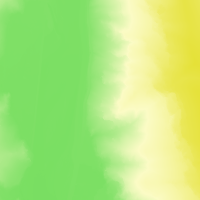

In [ ]:
Image(S.relief_tiny('../lidarhddata/SP/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif', res=5))

gdaldem slope /tmp/tiny.tif -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS  /tmp/tiny_slope.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny_slope.tif /home/eoubrayrie/mapproj/eslope/development/data/gdaldem-slope-eslo13bnear.clr /tmp/tiny_eslo13bnear.png -nearest_color_entry
0...10...20...30...40...50...60...70...80...90...100 - done.


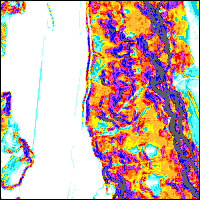

In [13]:
Image(S.eslo_tiny('../lidarhddata/SP.html/LHD_FXX_1037_6315_MNT_O_0M50_LAMB93_IGN69.tif', res=5))

In [ ]:
!ls ../lidarhddata

PM.html  QL.html  QN.html  RN.html  RP.html  SP.html
QK.html  QM.html  RL.html  RO.html  RQ.html


In [20]:
!gdalbuildvrt -vrtnodata -9999 -overwrite ../lidarhddata/SP.vrt ../lidarhddata/*/*.tif

/bin/bash: line 1: /ything/software/anaconda3/bin/gdalbuildvrt: Argument list too long


gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 200 -200 ../lidarhddata/SP.vrt /tmp/tiny.tif
Creating output file that is 210P x 315L.
Processing ../lidarhddata/SP.vrt [1/1] : 0Using internal nodata values (e.g. -9999) for image ../lidarhddata/SP.vrt.
Copying nodata values from source ../lidarhddata/SP.vrt to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


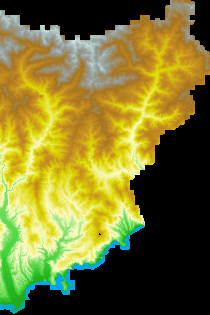

In [8]:
Image(S.relief_tiny('../lidarhddata/SP.vrt', res=200))

In [ ]:
with open("filelist.txt", 'w') as f_o:
    for f_i in Path('.').glob("*.zip"):
        with zipfile.ZipFile(f_i) as z:
            f_o.write(f"/vsizip/{f_i.name}/{z.namelist()[0]}\n")

In [9]:
!gdal_translate $S.DFLT_OPT ../lidarhddata/SP.vrt ../lidarhddata/SP.tif

Input file size is 84000, 126000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!gdalwarp ../lidarhddata/PM.html/*.tif $S.DFLT_OPT ../lidarhddata/PM.tif

ERROR 4: ./lidarhddata/PM.html/*.tif: No such file or directory
ERROR 4: Failed to open source file ./lidarhddata/PM.html/*.tif



In [ ]:
#dtm = S.merge_slopes(src='IGN-LIDARHD-PM.html')

---


### Build Piemont DTM

* 5m resolution
* It comes already in georeferenced TIF
* It uses projection *UTM 32N* aka *EPSG:32632*. Again we'll compute slopes **before** reprojecting.
* it uses `-a_nodata -99` (while gdal uses `-9999` - no, it's not confusing).


**Piemont** *(slope: 3 min → 1.6GB instead of 7GB uncompressed ; color 2 min → 1 GB)*:

```bash
cd $download ; unzip RIPRESA*TIF.zip ; cd $workdir
gdalbuildvrt piemont_dem.vrt $download/DTM5_*.tif
time gdaldem slope $=g_zstd $=g_tile piemont_dem.vrt piemont-utm32n-slope-tile.tif
time gdaldem color-relief $=g_zstd $=g_tile -alpha piemont-utm32n-slope.tif ../../gdaldem-slope-oslo.clr piemont-utm32n-oslo.tif
```


In [ ]:
rawfolder = NBROOT + '/data/dtm_local/piemont_raw/'
try: os.mkdir(rawfolder)
except FileExistsError: pass
os.chdir(rawfolder)

In [ ]:
!wget --wait=20 --random-wait --no-http-keep-alive --limit-rate=300k -nc -i ~/mapproj/eslope/development/data/piemonte-alpi-dtm5-urls.txt

In [ ]:
import zipfile
# files are like this RIPRESA_AEREA_ICE_2009_2011_DTM-SDO_CTR_FOGLI50-19-EPSG32632-TIF.zip
with open("piemont_filelist.txt", 'w') as f_o:
    for f_i in Path('.').glob("*.zip"):
        with zipfile.ZipFile(f_i) as z:
            f_o.write(f"/vsizip/{f_i.name}/{z.namelist()[0]}\n")

In [ ]:
!gdalbuildvrt -a_srs EPSG:23032 -srcnodata -99 -vrtnodata -99 dtm.vrt -input_file_list piemont_filelist.txt

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!gdal_translate $S.DFLT_OPT dtm.vrt piemont_dtm.tif

Input file size is 33210, 53394
0...10...20...30...40...50...60...70...80...90...100 - done.


gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 400 -400 ./piemont_dem.tif /tmp/tiny.tif
Creating output file that is 415P x 667L.
Processing ./piemont_dem.tif [1/1] : 0Using internal nodata values (e.g. -99) for image ./piemont_dem.tif.
Copying nodata values from source ./piemont_dem.tif to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


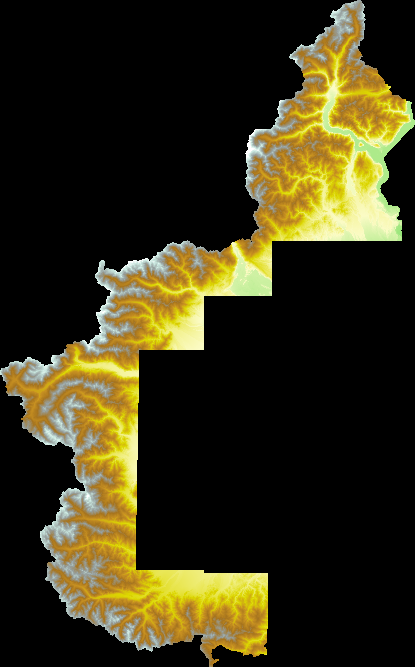

In [ ]:
Image(S.relief_tiny('../piemont_dtm.tif', res=400))

gdalwarp -overwrite -tr 400 -400 ./piemont_dem.tif /tmp/tiny.tif
Creating output file that is 415P x 667L.
Processing ./piemont_dem.tif [1/1] : 0Using internal nodata values (e.g. -99) for image ./piemont_dem.tif.
Copying nodata values from source ./piemont_dem.tif to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem slope /tmp/tiny.tif -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS  /tmp/tiny_slope.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny_slope.tif /home/eoubrayrie/mapproj/eslope/development/data/gdaldem-slope-eslo13bnear.clr /tmp/tiny_eslo13bnear.png -nearest_color_entry
0...10...20...30...40...50...60...70...80...90...100 - done.


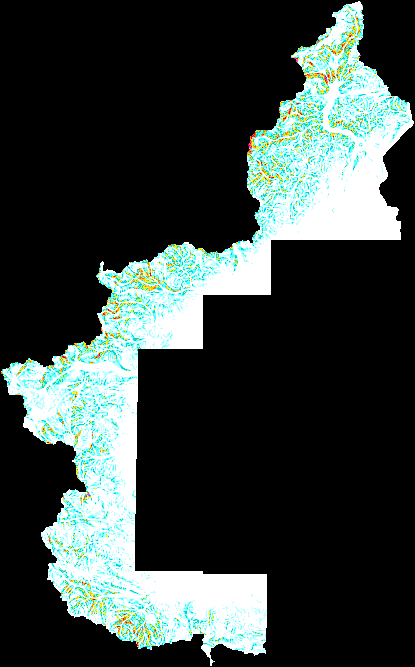

In [ ]:
Image(S.eslo_tiny('../piemont_dtm.tif', res=400, reuse=False))

### Build Aosta DTM

Aosta Valley 2005/2008 DEM, which has an even higher 2m resolution and is hosted [here](https://geoportale.regione.vda.it/download/dtm/) and uses *UTM ED50 32N* aka *EPSG:23032*.

In [33]:
rawfolder = NBROOT + '/data/dtm_local/aosta_raw/'
try: os.mkdir(rawfolder)
except FileExistsError: pass
os.chdir(rawfolder)

In [ ]:
!wget --wait=1 --random-wait --no-http-keep-alive -nc -i ~/mapproj/eslope/development/data/aosta-dtm0508-urls.txt


We use gdal's "[virtual file system](https://gdal.org/user/virtual_file_systems.html)" syntax to access inside zip files directly (aoste).

(!) For some reason trying to use `tiled=yes` for slopes does not work.


In [ ]:
%%bash
rm -f aosta_dtm_zips.txt ;
touch aosta_dtm_zips.txt ;
for f in DTM0508_002_000{001..914} ; do
    echo "/vsizip/{$f.zip}/$f.ASC" >> aosta_dtm_zips.txt ;
done

gdalbuildvrt -a_srs EPSG:23032 -srcnodata -9999 -vrtnodata -9999 aosta_dem.vrt -input_file_list aosta_dtm_zips.txt

Warning 1: gdalbuildvrt does not support heterogeneous band data type: expected Float32, got Int32. Skipping /vsizip/{DTM0508_002_000914.zip}/DTM0508_002_000914.ASC


0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!gdal_translate $S.DFLT_OPT aosta_dem.vrt ../aosta_dtm.tif

Input file size is 44174, 28557
0...10...20...30...40...50...60...70...80...90...100 - done.


gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 200 -200 ./aosta_dem.tif /tmp/tiny.tif
Creating output file that is 442P x 286L.
Processing ./aosta_dem.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image ./aosta_dem.tif.
Copying nodata values from source ./aosta_dem.tif to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


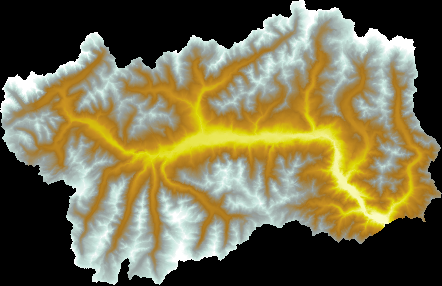

In [ ]:
Image(S.relief_tiny('../aosta_dtm.tif', res=200))

gdalwarp -overwrite -tr 200 -200 ./aosta_dem.tif /tmp/tiny.tif
Creating output file that is 442P x 286L.
Processing ./aosta_dem.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image ./aosta_dem.tif.
Copying nodata values from source ./aosta_dem.tif to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem slope /tmp/tiny.tif -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS  /tmp/tiny_slope.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny_slope.tif /home/eoubrayrie/mapproj/eslope/development/data/gdaldem-slope-eslo13bnear.clr /tmp/tiny_eslo13bnear.png -nearest_color_entry
0...10...20...30...40...50...60...70...80...90...100 - done.


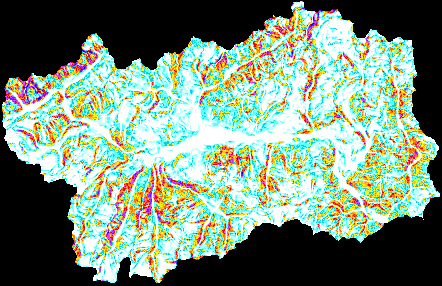

In [ ]:
Image(S.eslo_tiny('../aosta_dem.tif', res=200, reuse=False))

### Compute slope for CAlps DTMs

In [ ]:
dtmdir = Path('dtm_local')
for dtmname in ['ignalps_dtm.tif', 'trento_dtm.tif', 'styrol_dtm.tif', 'lombardia_dtm.tif', 'chc_dtm.tif']:
    dtm = dtmdir / dtmname
    if 'trento' in str(dtm):
        continue
    slope = str(dtm).replace('dtm', 'slope')
    if not exists(slope):
        cmd = f'''gdaldem slope {S.DFLT_OPT} {dtm} {slope}'''
        print(cmd)
        S.check_run(cmd)
    else:
        print('SKIP', slope)

# ch: 30min / trento: 30min / ign: 10min/etc

SKIP slope_local/tyrol_slope.tif
gdaldem slope -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS  dtm_local/lombardia_dtm.tif slope_local/lombardia_slope.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
SKIP slope_local/austria_slope.tif
SKIP slope_local/bavaria_slope.tif
SKIP slope_local/ignalps_slope.tif
SKIP slope_local/styrol_slope.tif
SKIP slope_local/chc_slope.tif


### Merge slopes

In [ ]:
# Put most precise last, for overlap
# those are in /wow/mapwow/dtm_local/
wsrc = (
        'slope_local/bavaria_slope.tif '    # 50m
        'slope_local/trento_slope.tif '     # 1m
)

In [ ]:
for z in (15, 16):
    S.merge_slopes(src=wsrc, dest=f'{SLOP_CX}_z{z}.tif', z=z, extent=bbox.bbcalps)
# z16: 16 minutes, 7GB
# z15: 12 minutes, 3GB


      gdalwarp -ot Byte \
        -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS -multi -wo NUM_THREADS=ALL_CPUS -overwrite  \
        -t_srs EPSG:3857 -tr 19.10925707129406 -19.10925707129406 -r q3 \
        -te_srs WGS84 -te 7.734 45.583 11.953 47.517  -dstnodata 255  \
        slope_local/bavaria_slope.tif slope_local/austria_slope.tif slope_local/lombardia_slope.tif slope_local/piemont_slope.tif slope_local/tyrol_slope.tif slope_local/styrol_slope.tif slope_local/aoste_slope.tif slope_local/chc_slope.tif slope_local/trento_slope.tif  alpsc/AlpsC_slope_z13.tif
Creating output file that is 24577P x 16385L.
Processing slope_local/bavaria_slope.tif [1/9] : 0Using internal nodata values (e.g. -9999) for image slope_local/bavaria_slope.tif.
...10...Processing slope_local/austria_slope.tif [2/9] : Using internal nodata values (e.g. -9999) for image slope_local/austria_slop

In [ ]:
for z in 14, 13, 12:
    S.make_ovr(src=f'{SLOP_CX}_z{z+2}.tif', dest=f'{SLOP_CX}_z{z}.tif', z=z, reuse=True)
# 1 GB / 200MB / 50 MB

      gdalwarp -r q3 -tr 38.21851414258813 -38.21851414258813 \
        -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS -multi -wo NUM_THREADS=ALL_CPUS -overwrite   \
        alpsc/AlpsC_slope_z14.tif alpsc/AlpsC_slope_z12.tif
Creating output file that is 12289P x 8192L.
Processing alpsc/AlpsC_slope_z14.tif [1/1] : 0Using internal nodata values (e.g. 255) for image alpsc/AlpsC_slope_z14.tif.
Copying nodata values from source alpsc/AlpsC_slope_z14.tif to destination alpsc/AlpsC_slope_z12.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


'alpsc/AlpsC_slope_z12.tif'

In [ ]:
files=[]
for z, cname in {
        16: 'eslo13near',
        15: 'eslo13near',
        14: 'eslo4near',
        13: 'eslo4near',  # TBD oslo3near
        12: 'eslo2',
    }.items():
        chkpoint = time()
        to_merge = S.slope_mbt(cname, z=z, src=f'{SLOP_CX}_z{z}.tif', dest=f'alpsc/AlpsC_{cname}_z{z}.mbtiles', reuse=True)
        files.append(os.path.expanduser(to_merge))  # f'{cname}-z{z}.mbtiles')
        print(f'Zoom {z} completed in {round(time()-chkpoint,1)} seconds')
S.mbt_merge(*files, dest=f'alpsc/AlpsC_eslo.mbtiles')

# 80 minutes

\
      sed 's/nv \+0 \+0 \+0/nv  255 255 255/g' \
          ~/code/eddy-geek/TIL/geo/data/gdaldem-slope-eslo13near.clr >! /tmp/gdaldem-slope-eslo13near.clr && \
      gdaldem color-relief alpsc/AlpsC_slope_z16.tif /tmp/gdaldem-slope-eslo13near.clr alpsc/AlpsC_eslo13near_z16.mbtiles \
          -nearest_color_entry -co TILE_FORMAT=png8 
0...10...20...30...40...50...60...70...80...90...100 - done.
Zoom 16 completed in 3376.5 seconds
\
      sed 's/nv \+0 \+0 \+0/nv  255 255 255/g' \
          ~/code/eddy-geek/TIL/geo/data/gdaldem-slope-eslo13near.clr >! /tmp/gdaldem-slope-eslo13near.clr && \
      gdaldem color-relief alpsc/AlpsC_slope_z15.tif /tmp/gdaldem-slope-eslo13near.clr alpsc/AlpsC_eslo13near_z15.mbtiles \
          -nearest_color_entry -co TILE_FORMAT=png8 
0...10...20...30...40...50...60...70...80...90...100 - done.
Zoom 15 completed in 914.4 seconds
\
      sed 's/nv \+0 \+0 \+0/nv  255 255 255/g' \
          ~/code/eddy-geek/TIL/geo/data/gdaldem-slope-eslo4near.clr >! /tmp/gd

In [ ]:
Image(S.eslo_tiny(SLOP_CX + '_z13.tif', res=S.resolutions[11]))

In [ ]:
!command -v aws && \
    aws s3 cp --acl public-read $STY_DTM s3://dtmlocal/

/ything/software/anaconda3/bin/aws
upload: ../dtm_local/styrol_dtm.tif to s3://dtmlocal/styrol_dtm.tif
